# Automata

## Editing Automata
Vcsn provides different means to enter automata.  One, which also applies to  plain Python, is using the `automaton` constructor:

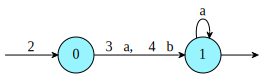

In [1]:
import vcsn
vcsn.automaton('''
context = "lal_char(ab), z
$ -> p <2>
p -> q <3>a,<4>b
q -> q a
q -> $
''')

See the documentation of `vcsn.automaton` for more details about this function.  The syntax used to define the automaton is, however, described here.

In order to facilitate the definition of automata, Vcsn provides additional ''magic commands'' to the IPython Notebook. We will see through this guide how use this command.

### `%%automaton`: Entering an Automaton

IPython supports so-called "cell magic-commands", that start with `%%`.  Vcsn provides the `%%automaton` magic command to enter the literal description of an automaton.  For instance, the automaton above can entered as follows:

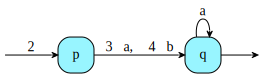

In [2]:
%%automaton a
context = "lal_char(ab), z"
$ -> p <2>
p -> q <3>a, <4>b
q -> q a
q -> $

The first argument, here `a`, is the name of the variable in which this automaton is stored:

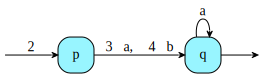

In [3]:
a

You may pass the option `-s` or `--strip` to strip the automaton from its layer that keeps the state name you have chosen.  In that case, the internal numbers are used, unrelated to the user names (actually, the numbers are assigned to state names as they are encountered starting from 0).

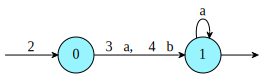

In [4]:
%%automaton --strip a
context = "lal_char(ab), z"
$ -> p <2>
p -> q <3>a, <4>b
q -> q a
q -> $

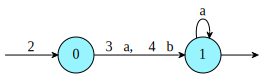

In [5]:
a

The second argument specifies the format in which the automaton is described, defaulting to `auto`, which means "guess the format":

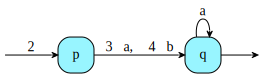

In [6]:
%%automaton a dot
digraph
{
  vcsn_context = "lal_char(ab), z"
  I -> p [label = "<2>"]
  p -> q [label = "<3>a, <4>b"]
  q -> q [label = a]
  q -> F
}

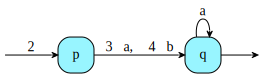

In [7]:
%%automaton a
digraph
{
  vcsn_context = "lal_char(ab), z"
  I -> p [label = "<2>"]
  p -> q [label = "<3>a, <4>b"]
  q -> q [label = a]
  q -> F
}

Automata entered this way are persistent: they are stored in the notebook and will be recovered when the page is reopened.

### `%automaton`: Text-Based Edition of an Automaton

In IPython "line magic commands" begin with a single `%`.  The line magic `%automaton` takes three arguments:
1. the name of the automaton
2. the format you want the textual description of the automaton. Defaults to `auto`.
3. the display mode: `h` for horizontal and `v` for vertical. Defaults to `h`.

Contrary to the cell magic, the `%automaton` can be used to update an existing automaton:

In [8]:
%automaton a

The real added value is that now you can interactively edit this automaton: changes in the text are immediately propagated on the rendered automaton.

When given a fresh variable name, `%automaton` creates a dummy automaton that you can use as a starting point:

In [9]:
%automaton b fado

Beware however that these automata are _not_ persistent: changes will be lost when the notebook is closed.

## Automata Formats

Vcsn supports differents input and output formats.  Some, such as `tikz`, are only export-only formats: they cannot be read by Vcsn.

### daut (read/write)
This simple format is work in progress: its precise syntax is still subject to changes.  It is roughly a simplification of the `dot` syntax.  The following example should suffice to understand the syntax.  If "guessable", the context can be left implicit.

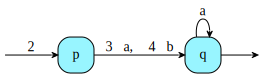

In [2]:
%%automaton a
context = "lal_char(ab), z"
$ -> p <2>
p -> q <3>a, <4>b
q -> q a
q -> $

### dot (read/write)
This format relies on the "dot" language of the GraphViz toolkit (http://graphviz.org).  This is the default format for I/O in Vcsn.

An automaton looks as follows:

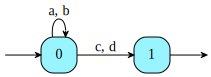

In [10]:
%%automaton a dot
// The comments are introduced with //, or /* ... */
//
// The overall syntax is that of Dot for directed graph ("digraph").
digraph
{
  // The following attribute defines the context of the automaton.
  vcsn_context = "lal_char, b"
  // Initial states are denoted by an edge between a node whose name starts
  // with an "I".  So "0" is a initial state.
  I -> 0
  // Transitions are edges whose label is that of the transition.
  0 -> 0 [label = "a"]
  0 -> 0 [label = "b"]
  0 -> 1 [label = "c, d"]
  // Final states are denoted by an edge to a node whose name starts with "F".
  1 -> Finish
}

### efsm (read/write)
This format is designed to support import/export with OpenFST (http://openfst.org): it wraps its multi-file format (one file describes the automaton with numbers as transition labels, and one or several others define these labels) into a single format.  It is not designed to be used by humans, but rather to be handled by two tools:
- `efstcompile` to compile such a file into the OpenFST binary file format,
- `efstdecompile` to extract an `efsm` file from a binary OpenFST file.

As an example, consider the following exchange between Vcsn and OpenFST.

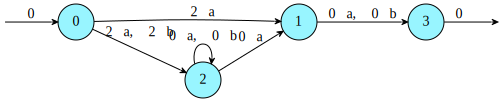

In [11]:
a = vcsn.context('lal_char(ab), zmin').expression('[ab]*a(<2>[ab])').automaton()
a

In [12]:
efsm = a.format('efsm')
print(efsm)

#! /bin/sh

me=$(basename "$0")
medir=$(mktemp -d "/tmp/$me.XXXXXX") || exit 1

arc_type=standard

cat >$medir/symbols.txt <<\EOFSM
\e	0
a	1
b	2
EOFSM

cat >$medir/transitions.fsm <<\EOFSM
0	1	a	2
0	2	a	2
0	2	b	2
1	3	a	0
1	3	b	0
2	1	a	0
2	2	a	0
2	2	b	0
3	0
EOFSM

fstcompile --acceptor \
  --arc_type=$arc_type \
  --keep_isymbols --isymbols=$medir/symbols.txt \
  --keep_osymbols --osymbols=$medir/symbols.txt \
  $medir/transitions.fsm "$@"
sta=$?

rm -rf $medir
exit $sta


The following sequence of operations uses OpenFST to determinize this automaton, and to load it back into Vcsn.

#! /bin/sh

me=$(basename "$0")
medir=$(mktemp -d "/tmp/$me.XXXXXX") || exit 1

arc_type=standard

cat >$medir/symbols.txt <<\EOFSM
\e	0
a	1
b	2
EOFSM

cat >$medir/transitions.fsm <<\EOFSM
0	1	a	2
0	2	b	2
1	3	a
1	4	b
2	1	a
2	2	b
3	3	a
3	4	b
3
4	1	a
4	2	b
4
EOFSM

fstcompile --acceptor \
  --arc_type=$arc_type \
  --keep_isymbols --isymbols=$medir/symbols.txt \
  --keep_osymbols --osymbols=$medir/symbols.txt \
  $medir/transitions.fsm "$@"
sta=$?

rm -rf $medir
exit $sta



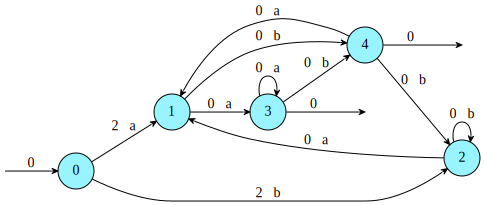

In [13]:
import os

# Save the EFSM description of the automaton in a file.
with open("a.efsm", "w") as file:
    print(efsm, file=file)

# Compile the EFSM into an OpenFST file.
os.system("efstcompile a.efsm >a.fst")

# Call OpenFST's determinization.
os.system("fstdeterminize a.fst >d.fst")

# Convert from OpenFST format to EFSM.
os.system("efstdecompile d.fst >d.efsm")

# Load this file into Python.
with open("d.efsm", "r") as file:
    d = file.read()
    
# Show the result.
print(d)

# Now read it as an automaton.
d_ofst = vcsn.automaton(d, 'efsm')
d_ofst

For what it's worth, the above sequence of actions is realized by `a.fstdeterminize()`.

Vcsn and OpenFST compute the same automaton.

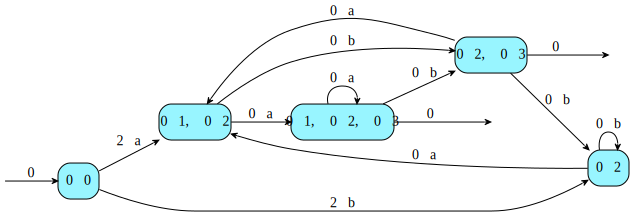

In [14]:
a.determinize()

### fado (read/write)
This is the native language of the FAdo platform (http://fado.dcc.fc.up.pt).  Weighted automata are not supported.

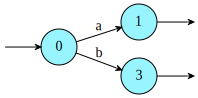

In [15]:
a = vcsn.B.expression('a+b').standard()
a

In [16]:
print(a.format('fado'))

@DFA 1 3
0 a 1
0 b 3


### grail (write)
This format is made to exchange automata with the Grail (http://grailplus.org). Weighted automata are not supported.

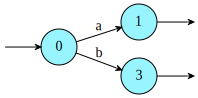

In [17]:
a = vcsn.B.expression('a+b').standard()
a

In [18]:
print(a.format('grail'))

(START) |- 0
0 a 1
0 b 3
1 -| (FINAL)
3 -| (FINAL)


### tikz (write)
This format generates a LaTeX document that uses TikZ syntax to draw the automaton.  Note that the layout is not computed: all the states are simply reported in a row.  You will have to tune the positions of the states by hand.  However, it remains a convenient way to start.

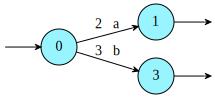

In [19]:
a = vcsn.Q.expression('<2>a+<3>b').standard()
a

In [20]:
print(a.format('tikz'))

\documentclass{standalone}
  \usepackage{tikz}
  \usetikzlibrary{arrows.meta, automata, bend, positioning, shapes.misc}
  \tikzstyle{automaton}=[shorten >=1pt, >={Stealth[bend,round]}, initial text=]
  \tikzstyle{accepting}=[accepting by arrow]

\begin{document}
\begin{tikzpicture}[automaton, auto]
  \node[state,initial] (0) {$0$};
  \node[state,accepting] (1) [right=of 0] {$1$};
  \node[state,accepting] (3) [right=of 1] {$3$};
  \path[->] (0) edge node {$\left\langle 2\right\rangle a$} (1);
  \path[->] (0) edge node {$\left\langle 3\right\rangle b$} (3);
\end{tikzpicture}
\end{document}
